Curve fitting of fold change values --> replaced through impported data of already fitted curves.

In [ ]:
x = np.array([1.1, 2.1, 3, 4.5, 5.3, 6])
y = np.array([1, 2.4, 3.1, 4.4, 5, 6.7])
plt.plot(x, y, 'o')

def linear(x, A, B):
    y = A*x + B
    return y

parameters, covariance = curve_fit(linear, x, y)

fit_y = linear(x, parameters[0], parameters[1])
plt.plot(x, y, 'o', label='data')
plt.plot(x, fit_y, '-', label='fit')
plt.legend()


protein = prokaryotes_all.groupby('Protein_ID')
protein_keys = list(protein.groups.keys())
temp = np.asarray(protein.get_group(protein_keys[0])['temperature'])
fold_change = np.asarray((protein.get_group(protein_keys[0])['fold_change']).astype('float64').min()/protein.get_group(protein_keys[0])['fold_change'].astype('float64'))
plt.plot(temp, fold_change, 'o')

Plotting change in meltpoint as boxplot or violinplot

In [ ]:
before_mutation_bs = np.array(mutated_proteins.loc[mutated_proteins['Organism'] == 'Escherichia coli (strain K12)','meltPoint'])
predicted_after_mutation_bs = np.array(mutated_proteins.loc[mutated_proteins['Organism'] == 'Escherichia coli (strain K12)','Mut_prediction'])
plt.figure(figsize=(10, 6))
data = np.concatenate([before_mutation_bs, predicted_after_mutation_bs])
labels = ['Before'] * len(before_mutation_bs) + ['After'] * len(predicted_after_mutation_bs)
sns.boxplot(x=labels, y=data, boxprops=dict(facecolor='blue', edgecolor='black', alpha = 0.2))
sns.stripplot(x=labels, y=data, color='black', jitter=True,)
plt.ylabel('Melting Points')
plt.title('Box Plot of Melting Points Before and After Mutation')
plt.show()

df_violin = pd.DataFrame({
    'Condition': ['Before Mutation'] * len(before_mutation_bs) + ['After Mutation'] * len(predicted_after_mutation_bs),
    'Melting Point': np.concatenate([before_mutation_bs, predicted_after_mutation_bs])
})
plt.figure(figsize=(10, 6))
sns.violinplot(x='Condition', y='Melting Point', data=df_violin, inner='point', palette='muted')
plt.title('Violin Plot of Melting Points Before and After Mutation')
plt.xlabel('Mutation Condition')
plt.ylabel('Melting Points')
plt.show()

paired t test with error

In [ ]:
def test(X, Y, X_err, Y_err):
    # Calculate the differences and their uncertainties
    D = Y - X
    D_err = np.sqrt(X_err**2 + Y_err**2)
    D_with_errors = [ufloat(d, d_err) for d, d_err in zip(D, D_err)]

    # Calculate the mean of the differences and its uncertainty
    mean_D = np.mean(D_with_errors)

    # Calculate the standard deviation of the differences
    n = len(D_with_errors)
    std_D = sqrt(sum((d - mean_D)**2 for d in D_with_errors) / (n - 1))

    # Calculate the t-statistic
    t_statistic = mean_D / (std_D / sqrt(n))

    # Extract the nominal value and uncertainty of the t-statistic
    t_value = t_statistic.nominal_value
    t_uncertainty = t_statistic.std_dev

    # Calculate the one-sided p-value (upper tail)
    p_value = t.cdf(-t_value, len(X) - 1)

    # Calculate the uncertainty in one-sided p-value (using error propagation)
    uncertainty_p_value = t.pdf(t_value, len(X) - 1) * t_uncertainty
    return pd.DataFrame([t_value, p_value, uncertainty_p_value], columns = ['t-statistics', 'p-value', 'uncertainty_p'])
    #return [t_value, p_value, uncertainty_p_value]

plot with p value shown

In [ ]:
data = mutated_proteins[['Organism', 'WT_prediction', 'Mut_prediction', 'meltPoint_x']]

# Melt the DataFrame to long format
df_melted = pd.melt(data, id_vars=['Organism'], 
                    value_vars=['meltPoint_x', 'WT_prediction', 'Mut_prediction'],
                    var_name='Condition', value_name = 'Tm Value')

# Plotting
# plt.figure(figsize=(14, 8))
# sns.boxplot(x='Condition', y='Tm Value', hue='Organism', data=df_melted, palette='deep')
# plt.title('Comparison of Melting Points for Different Conditions Across Organisms')
# plt.xlabel('Condition')
# plt.ylabel('Melting Point')
# plt.legend(title='Organism')
# plt.show()

######
# g = sns.catplot(x='Condition', y='Tm Value', col='Organism', 
#                 data=df_melted, kind='box', palette='deep', col_wrap=3, sharey=False)
# g.set_titles("{col_name}")
# g.set_axis_labels("Condition", "Melting Point")
# plt.subplots_adjust(top=0.9)
# g.figure.suptitle('Comparison of Melting Points for Different Conditions Across Organisms')
# plt.show()

p_values = {
    'Bacillus subtilis (strain 168)': 0.01,
    'Escherichia coli (strain K12)': 0.05,
    'Picrophilus torridus (strain ATCC 700027 / DSM 9790 / JCM 10055 / NBRC 100828 / KAW 2/3)': 0.001,
    'Thermus thermophilus (strain ATCC BAA-163 / DSM 7039 / HB27)': 0.001
}

plt.figure(figsize=(14, 8))
ax = sns.boxplot(x='Condition', y='Tm Value', hue='Organism', data=df_melted, palette='deep')

# Annotate p-values
def annotate_p_values(ax, p_values, conditions, y_offset=5):
    for organism, p_val in p_values.items():
        for condition in conditions:
            max_val = df_melted[(df_melted['Organism'] == organism) & (df_melted['Condition'] == condition)]['Tm Value'].max()
            x = conditions.tolist().index(condition) + 0.5
            y = max_val + y_offset
            ax.text(x, y, f'p = {p_val:.2e}', ha='center', fontsize=10, color='black')

# Customize the plot
conditions = df_melted['Condition'].unique()
annotate_p_values(ax, p_values, conditions)
plt.title('Comparison of Melting Points for Different Conditions Across Organisms')
plt.xlabel('Condition')
plt.ylabel('Melting Point')
plt.legend(title='Organism')
plt.show()

Monte carlo approach to calculate error of wilcoxon statistic

In [ ]:

def monte_carlo_wilcoxon(data1, data2, errors1, errors2, num_simulations=1000):
    # Perform the original Wilcoxon signed-rank test
    original_stat, original_p = wilcoxon(data1, data2)

    # Store results of simulations
    simulated_stats = []

    for _ in range(num_simulations):
        # Generate new data points by sampling from normal distributions centered at the original data points with the given errors
        sampled_data1 = np.random.normal(data1, errors1)
        sampled_data2 = np.random.normal(data2, errors2)

        # Perform Wilcoxon signed-rank test on the sampled data
        stat, _ = wilcoxon(sampled_data1, sampled_data2)
        simulated_stats.append(stat)

    # Calculate the mean and standard deviation of the simulated statistics
    mean_stat = np.mean(simulated_stats)
    std_stat = np.std(simulated_stats)
    
    return {
        'original_stat': original_stat,
        'p value': original_p,
        'mean_stat': mean_stat,
        'std_stat': std_stat,
        'simulated_stats': simulated_stats
    }

test = monte_carlo_wilcoxon(mutated_proteins['WT_prediction'], mutated_proteins['Mut_prediction'], abs(mutated_proteins['error_WTpred']), abs(mutated_proteins['error_Mutpred']))
print(f"Original Statistic: {test['original_stat']}")
print(f"Mean of Simulated Statistics: {test['mean_stat']}")
print(f"Standard Deviation of Simulated Statistics: {test['std_stat']}")
print(f"original pval: {test['p value']}")


import numpy as np
from scipy.stats import wilcoxon

def monte_carlo_wilcoxon(data1, data2, errors1, errors2, num_simulations=1000):
    # Check for negative errors
    if np.any(errors1 < 0) or np.any(errors2 < 0):
        raise ValueError("Error values must be non-negative")

    # Perform the original Wilcoxon signed-rank test
    original_stat, original_p = wilcoxon(data1, data2)

    # Store results of simulations
    simulated_stats = []

    for _ in range(num_simulations):
        # Generate new data points by sampling from normal distributions centered at the original data points with the given errors
        sampled_data1 = np.random.normal(data1, errors1)
        sampled_data2 = np.random.normal(data2, errors2)

        # Perform Wilcoxon signed-rank test on the sampled data
        stat, _ = wilcoxon(sampled_data1, sampled_data2)
        simulated_stats.append(stat)

    # Calculate the mean and standard deviation of the simulated statistics
    mean_stat = np.mean(simulated_stats)
    std_stat = np.std(simulated_stats)

    # Calculate the p-value based on the proportion of simulated stats more extreme than the original stat
    more_extreme_count = np.sum(np.abs(simulated_stats) >= np.abs(original_stat))
    p_value = more_extreme_count / num_simulations
    
    return {
        'original_stat': original_stat,
        'mean_stat': mean_stat,
        'std_stat': std_stat,
        'p_value': p_value,
        'simulated_stats': simulated_stats
    }


result = monte_carlo_wilcoxon(mutated_proteins['WT_prediction'], mutated_proteins['Mut_prediction'], abs(mutated_proteins['error_WTpred']), abs(mutated_proteins['error_Mutpred']))

print(f"Original Statistic: {result['original_stat']}")
print(f"Mean of Simulated Statistics: {result['mean_stat']}")
print(f"Standard Deviation of Simulated Statistics: {result['std_stat']}")
print(f"P-value: {result['p_value']}")


Archive for functional analysis

In [ ]:
#Group unique GO terms based on bioloigcal process:
GO_groups_bioprocess = prokaryotes_lysate.groupby(prokaryotes_lysate[n,'Gene Ontology (biological process)'].str.split(';').str[0])
GO_keys_bioprocess = list(GO_groups_bioprocess.groups.keys())
GO_keys_bioprocess = pd.Series(GO_keys_bioprocess)


#Group unique GO terms based on cellular component:
GO_groups_cellcomponent = prokaryotes_lysate.groupby(prokaryotes_lysate['Gene Ontology (cellular component)'].str.split(';').str[0])
GO_keys_cellcomponent = list(GO_groups_cellcomponent.groups.keys())

#Group unique GO terms based on molecular function:
GO_groups_molfunction = prokaryotes_lysate.groupby(prokaryotes_lysate['Gene Ontology (molecular function)'].str.split(';').str[0])
GO_keys_molfunction = list(GO_groups_molfunction.groups.keys())




from function import rel_aa_comp
from Aminoacid_lists import AA_hydrophobic, AA_polar_neutral, AA_acidic, AA_basic
prokaryotes_lysate['hydrophobic'] = prokaryotes_lysate['Sequence'].apply(lambda x: rel_aa_comp(x, AA_hydrophobic)) # calculates relative amino acid composition of hydrophobic amino acids
prokaryotes_lysate['polar_neutral'] = prokaryotes_lysate['Sequence'].apply(lambda x: rel_aa_comp(x, AA_polar_neutral)) # calculates relative amino acid composition of polar neutral amino acids
prokaryotes_lysate['acidic'] = prokaryotes_lysate['Sequence'].apply(lambda x: rel_aa_comp(x, AA_acidic)) # calculates relative amino acid composition of acidic amino acids
prokaryotes_lysate['basic'] = prokaryotes_lysate['Sequence'].apply(lambda x: rel_aa_comp(x, AA_basic)) # calculates relative amino acid composition of basic amino acids

# calculate the correlation between the relative amino acid composition and the melting point in each bio_process GO group:
corr_hydrophobic = GO_groups_bioprocess.apply(lambda x: x['meltPoint'].corr(x['hydrophobic']))
corr_polar_neutral = GO_groups_bioprocess.apply(lambda x: x['meltPoint'].corr(x['polar_neutral']))
corr_acidic = GO_groups_bioprocess.apply(lambda x: x['meltPoint'].corr(x['acidic']))
corr_basic = GO_groups_bioprocess.apply(lambda x: x['meltPoint'].corr(x['basic']))

# calculate the correlation between the relative amino acid composition and the melting point in each cell_comp GO group:
corr_hydrophobic_cellcomponent = GO_groups_cellcomponent.apply(lambda x: x['meltPoint'].corr(x['hydrophobic']))

# calculate the correlation between the relative amino acid composition and the melting point in each mol_function GO group:
corr_hydrophobic_molfunction = GO_groups_molfunction.apply(lambda x: x['meltPoint'].corr(x['hydrophobic']))

# sns.barplot(x=correlation_hydrophobic.index, y=correlation_hydrophobic)
# plt.title('Correlation between relative amino acid composition of hydrophobic amino acids and melting point in different GO groups')
# plt.xlabel('GO group')
# plt.ylabel('Correlation')
# plt.show()


from function import p_val
pval = GO_keys_bioprocess.apply(lambda x: p_val(corr_hydrophobic[x], GO_groups_bioprocess.size()[x], 0.05))


# differences in meltpoint and variable for all species
from function import diff
test = pd.Series(['hydrophobic', 'polar_neutral', 'acidic', 'basic'])
differences_hyrophobic = pd.Series(prokaryotes_lysate['run_name'].unique())[np.r_[0:3, 4]].apply(lambda x: diff(GO_groups_bioprocess, x, 'hydrophobic'))
differences_hyrophobic.index = ['B. subtilis', 'E. coli', 'O. antarctica','P. torridus']



data = {
    'Organism': ['Org1', 'Org1', 'Org1', 'Org2', 'Org2', 'Org3', 'Org3'],
    'GO_Group': ['GO1', 'GO1', 'GO2', 'GO1', 'GO2', 'GO1', 'GO2'],
    'Solution': [10, 12, 14, 16, 18, 20, 22],
    'Max_Growth_Temperature': [37, 37, 37, 42, 42, 50, 50]
}

for n in GO_groups_bioprocess.index():
    if GO_groups_bioprocess[n, 'Organism']
    mean_solution = GO_groups_bioprocess[n, 'Solution'].mean().reset_index()

# Merge to include the maximal growth temperature
mean_solution = mean_solution.merge(df[['Organism', 'Max_Growth_Temperature']].drop_duplicates(), on='Organism')

# Calculate the difference
mean_solution['Difference'] = mean_solution['Solution'] - mean_solution['Max_Growth_Temperature']

# Prepare the pivot table
pivot_table = mean_solution.pivot(index='Organism', columns='GO_Group', values='Difference')


Maxi essential proteins//heatmap

In [ ]:

# import data

path: str = './data/' #folder where files are stored
prokaryotes_all: pd.DataFrame = pd.read_csv(os.path.join(path, "prokaryotes_all.csv"), dtype=str)
prokaryotes_values: pd.DataFrame = pd.read_csv(os.path.join(path, "prokaryotes_funct.csv"), dtype=str)

prokaryotes_lysate: pd.DataFrame = pd.read_csv(os.path.join(path, "prokaryotes_322columns.csv"))

prokaryotes_values['a_point'] = prokaryotes_values['a_point'].astype('float64')
prokaryotes_values['b_point'] = prokaryotes_values['b_point'].astype('float64')
prokaryotes_values['plateau'] = prokaryotes_values['plateau'].astype('float64')
prokaryotes_values['meltPoint'] = prokaryotes_values['meltPoint'].astype('float64')
# x = np.array([1.1, 2.1, 3, 4.5, 5.3, 6])
# y = np.array([1, 2.4, 3.1, 4.4, 5, 6.7])
# plt.plot(x, y, 'o')

# def linear(x, A, B):
#     y = A*x + B
#     return y

# parameters, covariance = curve_fit(linear, x, y)

# fit_y = linear(x, parameters[0], parameters[1])
# plt.plot(x, y, 'o', label='data')
# plt.plot(x, fit_y, '-', label='fit')
# plt.legend()
# protein = prokaryotes_all.groupby('Protein_ID')
# protein_keys = list(protein.groups.keys())
# temp = np.asarray(protein.get_group(protein_keys[0])['temperature'])
# fold_change = np.asarray((protein.get_group(protein_keys[0])['fold_change']).astype('float64').min()/protein.get_group(protein_keys[0])['fold_change'].astype('float64'))
# plt.plot(temp, fold_change, 'o')

def curve_equation(x, a, b, plateau, target):
    rel_amount = ((1-plateau)/(1+(np.power(np.e, (-a/x)+b)))) + plateau
    return rel_amount - target
from scipy.optimize import fsolve
prokaryotes_values['solution'] = pd.Series(prokaryotes_values.index).apply(lambda i: fsolve(curve_equation, prokaryotes_values.loc[i, 'meltPoint'], args=(prokaryotes_values.loc[i,'a_point'], prokaryotes_values.loc[i,'b_point'], prokaryotes_values.loc[i,'plateau'], 0.1)))
prokaryotes_values = prokaryotes_values[prokaryotes_values['solution'] < 100]
#essential_proteins_bs = prokaryotes_values[(prokaryotes_values['Sample'] == 'B.subtilis_P023755') & (prokaryotes_values['solution'] < 54) & (prokaryotes_values['solution'] > 52)]

prokaryotes_lysate=prokaryotes_lysate.reset_index().merge(prokaryotes_values.reset_index(), on='Protein_ID', how='inner')

prokaryotes_lysate = prokaryotes_lysate.drop(columns=prokaryotes_lysate.columns[30:318])
#add GO groups to dataframe
# for n in prokaryotes_lysate.index:
#     if pd.notna(prokaryotes_lysate.loc[n, 'Gene Ontology (biological process)']):
#         prokaryotes_lysate.loc[n, 'GO_Group'] = prokaryotes_lysate.loc[n,'Gene Ontology (biological process)'].str.split(';').str[0]

# Iterate over the rows in the DataFrame
for n in prokaryotes_lysate.index:
    go_process = prokaryotes_lysate.loc[n, 'Gene Ontology (biological process)']
    if pd.notna(go_process):
        prokaryotes_lysate.loc[n, 'GO_Group'] = go_process.split(';')[0]

for n in prokaryotes_lysate.index: 
    if prokaryotes_lysate.loc[n,'Organism'] == 'Bacillus subtilis (strain 168)':
        prokaryotes_lysate.loc[n, 'max_temp'] = 53 
    elif prokaryotes_lysate.loc[n, 'Organism'] == 'Escherichia coli (strain K12)':
        prokaryotes_lysate.loc[n, 'max_temp'] = 46 
    elif prokaryotes_lysate.loc[n, 'Organism'] == 'Oleispira antarctica RB-8':
        prokaryotes_lysate.loc[n, 'max_temp'] = 28
    elif prokaryotes_lysate.loc[n, 'Organism'] == 'Thermus thermophilus (strain ATCC BAA-163 / DSM 7039 / HB27)':
        prokaryotes_lysate.loc[n, 'max_temp'] = 82
    elif prokaryotes_lysate.loc[n, 'Organism'] == 'Escherichia coli str. K-12 substr. MG1655':
        prokaryotes_lysate.loc[n, 'max_temp'] = 46
    elif prokaryotes_lysate.loc[n, 'Organism'] == 'Picrophilus torridus (strain ATCC 700027 / DSM 9790 / JCM 10055 / NBRC 100828 / KAW 2/3)':
        prokaryotes_lysate.loc[n, 'max_temp'] = 66
GO_groups_bioprocess = prokaryotes_lysate.groupby(prokaryotes_lysate['Gene Ontology (biological process)'].str.split(';').str[0])
GO_keys_bioprocess = list(GO_groups_bioprocess.groups.keys())
GO_keys_bioprocess = pd.Series(GO_keys_bioprocess)
heatmap_1 = pd.DataFrame()

# for key, group in GO_groups_bioprocess:
#     for n in group:
#         if group[n,'Organism'] == 'Bacillus subtilis (strain 168)':
#             print(group[n,'Organism'])

for name, group in GO_groups_bioprocess:
    print(f"GO Group {name}:")
    organism_df = group[group['Organism'] == 'Bacillus subtilis (strain 168)']
    if not organism_df.empty:
        mean_solution = organism_df['solution'].mean()
        print(f"Mean 'solution' for {'Bacillus subtilis (strain 168)'} in group {name}: {mean_solution}")
    else:
        print(f"{'Bacillus subtilis (strain 168)'} not found in group {name}")

organisms = prokaryotes_lysate['Organism'].unique()
matrix = pd.DataFrame(index=GO_groups_bioprocess.groups.keys(), columns=organisms)

for name, group in GO_groups_bioprocess:
    for organism in organisms:
        organism_df = group[group['Organism'] == organism]
        if not organism_df.empty:
            mean_solution = organism_df['solution'].mean()
            max_temp = organism_df['max_temp'].iloc[0]
            difference = abs(mean_solution - max_temp)
            matrix.at[name, organism] = difference
matrix1 = matrix.apply(pd.to_numeric, errors='coerce').fillna(100)

print(matrix)

matrix2 = matrix1.astype(float)
matrix2= matrix2.drop(['Escherichia coli str. K-12 substr. MG1655','Thermus thermophilus','Escherichia coli O157:H7',], axis=1)

plt.figure(figsize=(10, 40))
heatmap = sns.heatmap(matrix2, annot=False, cmap='coolwarm', center=0, )
plt.title('Heatmap of Differences Between Mean Solution and Max Temp')
plt.xlabel('Organism')
plt.ylabel('GO Group')
plt.show()
matrix3 = matrix2[(matrix2 == 100).sum(axis=1) < 4]

plt.figure(figsize=(10, 60))
heatmap = sns.heatmap(matrix3, annot=False, cmap='coolwarm', center=0 )
plt.title('Heatmap of Differences Between Mean Solution and Max Temp')
plt.xlabel('Organism')
plt.ylabel('GO Group')
plt.show()
matrix4 = matrix.astype(float)
matrix4= matrix4.drop(['Escherichia coli str. K-12 substr. MG1655','Thermus thermophilus','Escherichia coli O157:H7',], axis=1)
matrix4 = matrix4[matrix4.isnull().sum(axis=1) < 4]

plt.figure(figsize=(10, 80))
heatmap = sns.heatmap(matrix4, annot=False, cmap='gist_heat', center=0, mask=matrix4.isnull() )
plt.title('Heatmap of Differences Between Mean Solution and Max Temp')
plt.xlabel('Organism')
plt.ylabel('GO Group')
plt.show()
matrix3 = matrix2[matrix2.isnull().sum(axis=1) < 4]
matrix3 = matrix3.drop(columns='Oleispira antarctica RB-8')
matrix3 = matrix3.drop(columns='Thermus thermophilus (strain ATCC BAA-163 / DSM 7039 / HB27)')


for n in matrix3.index:
    for x in matrix3.columns:
        if matrix3.loc[n, x] > 15:
            matrix3.loc[n, x] = np.nan

matrix3 = matrix3[matrix3.isnull().sum(axis=1) < 2]
            


plt.figure(figsize=(5,40))
heatmap = sns.heatmap(matrix3, annot=False, cmap='viridis', center=5 )
plt.title('Heatmap of Differences Between Mean Solution and Max Temp')
plt.xlabel('Organism')
plt.ylabel('GO Group')
plt.show()

In [ ]:
for i in prokaryotes_lysate.index:
    prokaryotes_lysate['Gene Ontology (biological process)'] = prokaryotes_lysate['Gene Ontology (biological process)'].fillna('Unknown')
    if any(word in prokaryotes_lysate.loc[i, 'Gene Ontology (biological process)'] for word in ['transport', 'localization', 'protein', 'chaperone', 'assembly']):
        prokaryotes_lysate.loc[i, 'Gene Ontology (biological process)_obscure'] = 'Protein Transport/Folding'
    elif any(word in prokaryotes_lysate.loc[i, 'Gene Ontology (biological process)'] for word in ['metabolism', 'biosynthesis', 'catabolism', 'metabolic', 'anabolism', 'glycolysis', 'glycolytic', 'glucose', 'catabolic', 'biosynthetic', 'synthesis', 'carbon', 'fixation', 'respiration', 'salvage', 'gluconeogenesis', 'beta-oxidation']):
        prokaryotes_lysate.loc[i, 'Gene Ontology (biological process)_obscure'] = 'Metabolism'
    elif any(word in prokaryotes_lysate.loc[i, 'Gene Ontology (biological process)'] for word in ['RNA', 'transcription', 'translation', 'ribosome', 'mRNA', 'tRNA', 'rRNA', 'snoRNA', 'snRNA', 'siRNA', 'piRNA']):
        prokaryotes_lysate.loc[i, 'Gene Ontology (biological process)_obscure'] = 'Transcription/Translation'
    elif any(word in prokaryotes_lysate.loc[i, 'Gene Ontology (biological process)'] for word in ['replication', 'repair', 'damage', 'nucleotide', 'methylation']):
        prokaryotes_lysate.loc[i, 'Gene Ontology (biological process)_obscure'] = 'DNA Replication/Repair'
    elif any(word in prokaryotes_lysate.loc[i, 'Gene Ontology (biological process)'] for word in ['cell', 'division', 'cycle', 'growth', 'cellular', 'mitosis', 'meiosis', 'cytokinesis', 'chromosome', 'spindle', 'centrosome', 'centriole', 'centromere', 'kinetochore', 'telomere', 'nucleus', 'nuclear', 'nucleolus']):
        prokaryotes_lysate.loc[i, 'Gene Ontology (biological process)_obscure'] = 'Cell Division/Cycle'
    elif prokaryotes_lysate.loc[i, 'Gene Ontology (biological process)'] != 'Unknown':
        prokaryotes_lysate.loc[i, 'Gene Ontology (biological process)_obscure'] = 'Other'

In [ ]:
result = essential_proteins.groupby(['Organism', 'Gene Ontology (biological process)_obscure']).size().reset_index(name='Protein_Count')
organism_dfs = {org: group for org, group in result.groupby('Organism')}
org1_df = organism_dfs['Bacillus subtilis (strain 168)']
org2_df = organism_dfs['Escherichia coli (strain K12)']
combined_df_essentials = pd.concat([org1_df, org2_df], ignore_index=True)

In [ ]:
result2 = prokaryotes_lysate.groupby(['Organism', 'Gene Ontology (biological process)_obscure']).size().reset_index(name='Protein_Count')
organism_dfs2 = {org: group for org, group in result2.groupby('Organism')}
org1_df2 = organism_dfs2['Bacillus subtilis (strain 168)']
org2_df2 = organism_dfs2['Escherichia coli (strain K12)']
combined_df_lys = pd.concat([org1_df2, org2_df2], ignore_index=True)

In [ ]:
fraction = pd.DataFrame()
for n in combined_df_lys['Gene Ontology (biological process)_obscure'].unique():
    fraction[n] = combined_df_essentials[combined_df_essentials['Gene Ontology (biological process)_obscure'] == n]['Protein_Count'].values / combined_df_lys[combined_df_lys['Gene Ontology (biological process)_obscure'] == n]['Protein_Count'].values
fraction.columns= combined_df_lys['Gene Ontology (biological process)_obscure'].unique()
fraction.index = ['B. subtilis', 'E. coli']

In [ ]:
fraction.iloc[0,:]

Cell Division/Cycle          0.120690
DNA Replication/Repair       0.074074
Metabolism                   0.074074
Other                        0.078431
Protein Transport/Folding    0.073864
Transcription/Translation    0.056180
Name: B. subtilis, dtype: float64

C:\Users\tobia\AppData\Local\Temp\ipykernel_14228\2391206366.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraction.columns, y = fraction.iloc[1,:], palette='deep')
C:\Users\tobia\AppData\Local\Temp\ipykernel_14228\2391206366.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Biological process')


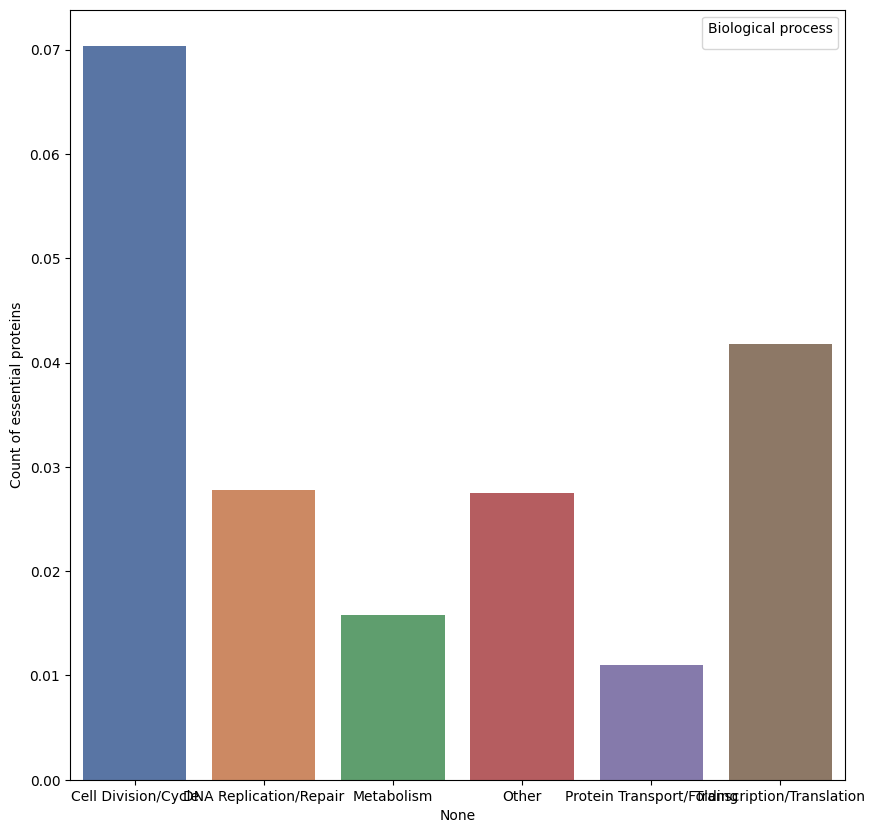

In [ ]:
plt.figure(figsize=(10, 10))
#sns.barplot(x=fraction.columns, y = fraction.iloc[0,:], palette='deep')
sns.barplot(x=fraction.columns, y = fraction.iloc[1,:], palette='deep')
plt.ylabel('Count of essential proteins')
plt.legend(title='Biological process')
plt.show()